In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import segmentation_models_pytorch as smp
import torch.nn as nn
import matplotlib.pyplot as plt

In [45]:
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [46]:
class HydrationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        image = image/255.0   ##### QQ
        mask = mask/255.0     ##### QQ

        image = torch.tensor(image).permute(2,0,1).float()  # opencv: (H, W, C) -> pytorch: (C, H, W) & float32 type
        mask = torch.tensor(mask).unsqueeze(0).float()      # (H, W) -> (1, H, W)

        return image, mask

In [47]:
image_dir = "/Users/yeonji/Desktop/ComputerProject/CNN_HS_Predict/image/protein/"
mask_dir = "/Users/yeonji/Desktop/ComputerProject/CNN_HS_Predict/image/hs/"

In [65]:
fulldataset = HydrationDataset(image_dir, mask_dir)
train_size = int(0.8*len(fulldataset))
test_size = len(fulldataset) - train_size

In [66]:
train_data, test_data = torch.utils.data.random_split(fulldataset, [train_size, test_size])

In [67]:
train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")
model = smp.Unet(encoder_name="resnet18", in_channels=3, classes=1).to(device)    # you can think as a number of channels of output mask

In [69]:
bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

In [70]:
def combined_loss(pred, target):
    return 0.5 * bce_loss(pred, target) + 0.5 * dice_loss(pred, target)

In [71]:
optimizer = torch.optim.Adam(model.parameters())

In [72]:
epochs=10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        loss = combined_loss(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/10 - Loss: 0.6573
Epoch 2/10 - Loss: 0.5432
Epoch 3/10 - Loss: 0.5203
Epoch 4/10 - Loss: 0.5113
Epoch 5/10 - Loss: 0.5037
Epoch 6/10 - Loss: 0.5010
Epoch 7/10 - Loss: 0.4969
Epoch 8/10 - Loss: 0.4910
Epoch 9/10 - Loss: 0.4896
Epoch 10/10 - Loss: 0.4870


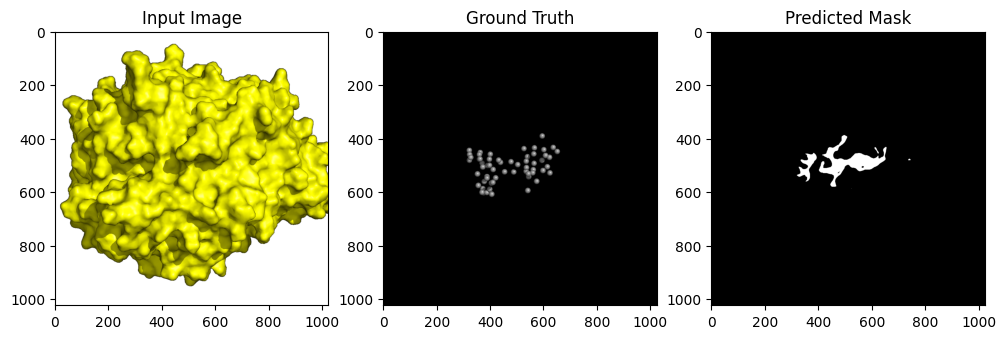

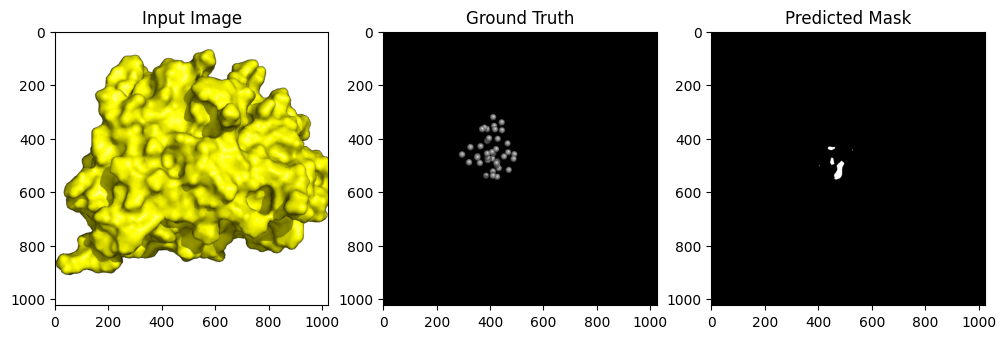

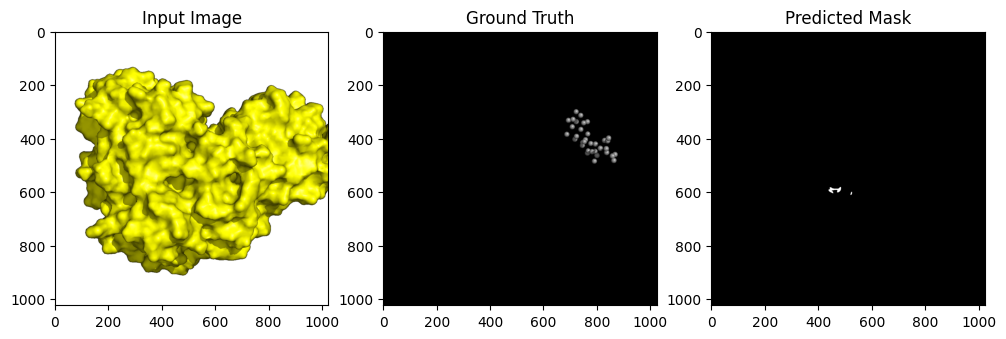

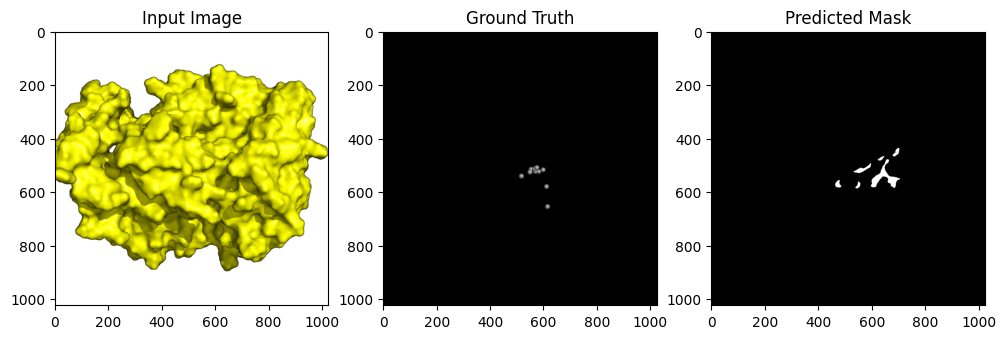

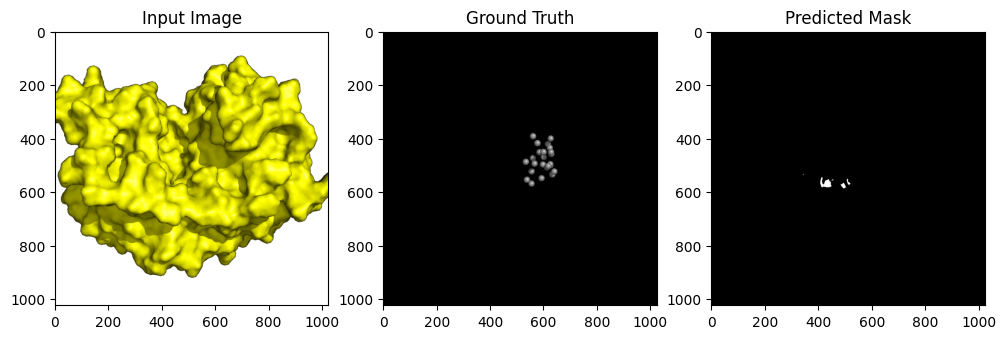

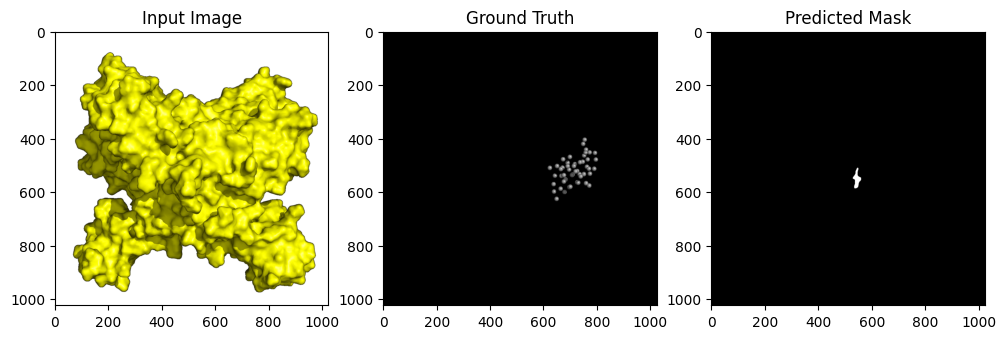

In [74]:
model.eval()
with torch.no_grad():
    for i, (img, mask) in enumerate(test_loader):
        img = img.to(device)
        output = model(img)
        pred = torch.sigmoid(output).cpu().numpy()[0, 0]

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(img.cpu().squeeze().permute(1, 2, 0))
        axs[0].set_title("Input Image")
        axs[1].imshow(mask.squeeze(), cmap="gray")
        axs[1].set_title("Ground Truth")
        axs[2].imshow(pred > 0.1, cmap="gray")
        axs[2].set_title("Predicted Mask")
        plt.show()

        if i == 5:
            break  # 3개만 시각화

In [37]:
def dice_score(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection) / (pred.sum() + target.sum() + epsilon)

In [38]:
def iou_score(pred, target, epsilon=1e-6):
    pred = (pred > 0.5).float()
    target = (target > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return intersection / (union + epsilon)

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score

def classification_metrics(pred, target):
    pred_bin = (pred > 0.5).cpu().numpy().flatten()
    target_bin = (target > 0.5).cpu().numpy().flatten()
    
    precision = precision_score(target_bin, pred_bin)
    recall = recall_score(target_bin, pred_bin)
    f1 = f1_score(target_bin, pred_bin)
    
    return precision, recall, f1

In [41]:
dice_total, iou_total = 0, 0

for img, mask in test_loader:
    img, mask = img.to(device), mask.to(device)
    output = model(img)
    pred = torch.sigmoid(output)

    dice_total += dice_score(pred, mask).item()
    iou_total += iou_score(pred, mask).item()

print(f"Avg Dice: {dice_total/len(test_loader):.4f}, Avg IoU: {iou_total/len(test_loader):.4f}")


Avg Dice: 0.0000, Avg IoU: 0.0000


In [44]:
print(torch.max(pred), torch.min(pred), torch.mean(pred))


tensor(0.0955, grad_fn=<MaxBackward1>) tensor(0.0010, grad_fn=<MinBackward1>) tensor(0.0048, grad_fn=<MeanBackward0>)
